In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Для тепловых карт
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

## Функции активации и их дифференциал

In [2]:

def sigmoid(x):
  return 1 / (1 + np.exp(-x))


def dsigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

sig_f = (sigmoid, dsigmoid)

def simpl_f(x):
  res = np.copy(x)
  res[res >= 0] = 1
  res[res < 0] = 0
  return res


def tanh(x):
  return np.tanh(x)


def dtanh(x):
  return 1 - np.square(tanh(x))

tanh_f = (tanh, dtanh)

# Средняя квадратичная ошибка
def mse(y_pred, y):
  # 1/n*sum((угаданное-Y)^2)
  err = np.mean(np.square(y_pred - y))
  return err


# y_pred - рассчитанное значение, y - ожидаемое
def dmse(y_pred, y):
  n = y.shape[0]
  return (2 / n) * (y_pred - y)

In [3]:
# Визуализация весов модели
def visualize_weights_with_biases(weights, biases, title='График'):
  """
  Делает тепловую карту для весов и смещения каждого нейрона каждого слоя

  -----
  :param weights: матрица размерности (k*i*j) где k- количество весов, i - нейроны текущего слоя, j - входы в нейрон
  :param biases: матрица размерности (k*i*1)
  :param title: Название для графиков (опционально)
  :return: none
  """
  for i, (weights, bias) in enumerate(zip(weights, biases)):
    # Транспонируем матрицу весов для замены строк и колонок
    weights_t = weights.T
   # добавляем смещение как дополнительную строку
    bias_row = bias.reshape(1, -1)
    combined_matrix = np.vstack([weights_t, bias_row])

    # Визуализируем тепловую карту
    plt.figure(figsize=(10, 6))
    sns.heatmap(combined_matrix, annot=False, cmap='coolwarm', cbar=True)
    plt.title(f'{title} для слоя {i + 1}')
    plt.xlabel('Нейроны')
    plt.ylabel('Вход и смещение(последнее)')
    plt.show()

In [4]:
def get_batches(data, batch_size):
  n = len(data)
  get_X = lambda z: z[0]
  get_y = lambda z: z[1]
  for i in range(0, n, batch_size):
    batch = data[i:i+batch_size]
    yield np.array([get_X(b) for b in batch]), np.array([get_y(b) for b in batch])

# Класс модели (возможно стоит выделить в отдельную библиотеку)

In [5]:
class MLP:
  """ Классический многослойный персептрон"""
  def __init__(self, architecture, lr=0.01, is_need_f_final=False, fn=(sigmoid, dsigmoid)):
    self.depth = len(architecture) - 1
    self.lr = lr
    # Требуется ли активационная функция на выходном слое
    self._is_need_func_final = is_need_f_final

    self.activation_fn = fn[0]
    self.activation_dfn = fn[1]

    self.error_fn = mse
    self.error_dfn = dmse

    #TODO: добавить сохранение весов и смещения, чтобы сохранять успешное обучение между запусками
    # Веса (k, i, j - k: номер слоя 0 = первый скрытый слой; i - конкретный нейрон; j - нейрон предыдущего слоя)
    self.W = self._init_weights(architecture)
    # Смещение (или порог активации)
    # (k, i, j - k: номер слоя 0 = первый скрытый слой; i - конкретный нейрон; j=1)
    self.b = self._init_biases(architecture)


# Прямое направление
    # Сумматор
    self.z = [None] * (self.depth+1)
    # Результат функции активации (кроме последнего слоя) (k: номер слоя: 0 - вход, 1 - первый скрытый слой; j количество нейронов на слое; l - количество данных на батч
    self.a = [None] * (self.depth+1)

    #Дельта правило (при инициализации заполняются 0)
    self.dW = [np.zeros_like(w) for w in self.W]
    self.db = [np.zeros_like(b) for b in self.b]

    # glorot uniform init
  def _init_weights(self, arch):
    net_in = arch[0]
    net_out = arch[-1]
    limit = np.sqrt(6. / (net_in + net_out))
    return [rng.uniform(-limit, limit + 1e-5, size=(arch[i+1], arch[i])) for i in range(self.depth)]

  def _init_biases(self, arch):
    return [rng.random((arch[i+1],1))*2-1 for i in range(self.depth)]

  def set_weights(self, new_W):
    self.W = new_W

  def set_biases(self, new_b):
    self.b = new_b

  def compute_loss(self, X, y):
    # X[l][in]
    y_pred = self.predict(X).reshape(y.shape)
    return self.error_fn(y_pred, y)

  # Расчет прямого прохождения для нескольких X
  def _feedforward(self, X):
    # W[0].shape[1] - количество входов = net_in
    # -1; X.shape[0] - количество значений в батче
    self.a[0] = X.T.reshape(self.W[0].shape[1], -1)
    # рассчитываем скрытые и выходной слои
    for k in range(self.depth):
      # перемножаются W [i (текущий слой), j (предыдущий)] * a[j (количество нейронов), l (количество в батче)]
      self.z[k+1] = np.matmul(self.W[k], self.a[k]) + self.b[k]
      # Выполняется только для скрытых слоев либо если передан _is_need_func_final
      #TODO : добавить отдельную функцию активации для выходного слоя
      if k != self.depth-1 or self._is_need_func_final:
        self.a[k+1] = self.activation_fn(self.z[k+1])
      else:
        self.a[-1] = self.z[-1]

# Расчет локального градиента при обратном распространении ошибок
  def _backprop(self, y, batch_size=32):
    # TODO сделать delta для выходящего слоя при _is_need_func_final и конкретной функции
    # a[j, l], y[l, in] -> y[in, l]
    delta = self.error_dfn(self.a[-1], y.T)
    if self._is_need_func_final:
      delta *= self.activation_dfn(self.z[-1])
    for k in range(self.depth-1, 0, -1):
      # Идем в обратном порядке. k - текущий слой, k+1 уже подсчитанный. j - количество нейронов в текущем слое. i - количество нейронов в k+1 слое
      if k != self.depth-1:

      # f(z[i][l]) * (dot (W[j][i], delta[i][l]) получаем [j][l], так как для W[k].shape(i) = z[k].shape(j)
        delta = self.activation_dfn(self.z[k+1]) * np.matmul(self.W[k+1].T, delta)
      # dot(delta[j][l], a[l][j]) должны получить dW[i, j]
      self.dW[k] = np.matmul(delta, self.a[k].T)
      # delta[j][1] sum l
      self.db[k] = np.sum(delta, axis=1, keepdims=True)

  # simple sgd
  def _update_params(self, lr=1e-2):
    for k in range(self.depth):
      self.W[k] -= lr*self.dW[k]
      self.b[k] -= lr*self.db[k]

  def train(self, X, y, lr=None, epochs=50, batch_size=32):
    """
    Обучение модели.

    -------
    :param X: Размерности l * in, где l количество входящих данных, in - количество входов
    :param y: Размерности l * out.
    :param lr:  learning rate, по умолчанию берет значение из MLP.lr
    :param epochs: Количество эпох, по умолчанию 50.
    :param batch_size: Количество данных в одном батче. По умолчанию 32.
    :return: Возвращает вектора loss и dW(mean каждого слоя) по эпохам
    """
    # n = y.shape[0]
    lr = lr if lr is not None else self.lr

    epoch_losses = np.array([])
    epoch_grad_w = np.zeros((len(self.dW), epochs))
    dataset = list(zip(X, y))
    for i in range(epochs):
      rng.shuffle(dataset)
      for (X_batch, y_batch) in get_batches(dataset, batch_size):
        self._feedforward(X_batch)
        self._backprop(y_batch)
        self._update_params(lr=lr)

      epoch_losses = np.append(epoch_losses, self.compute_loss(X, y))
      for k in range(len(self.dW)):
        epoch_grad_w[k][i] = np.mean(self.dW[k])
    return epoch_losses, epoch_grad_w

  def predict(self, X):
    """
    Предсказать значение на уже обученной модели.

    ------
    :param X:На вход X размерности l * out, где l - количество полученных данных, out - количество выходящих нейронов.
    :return: Возвращает a размерности l * out
    """
    a = X.T.reshape(self.W[0].shape[1], -1)
    # compute hidden and output layers
    for i in range(self.depth):
      a = np.matmul(self.W[i], a) + self.b[i]
      if i != self.depth-1 or self._is_need_func_final:
        a = self.activation_fn(a)
    return a

In [6]:
# Используем модель

In [7]:
X_train = np.array([
    [-1, -1, -1],
    [-1, -1, 1],
    [-1, 1, -1],
    [-1, 1, 1],
    [1, -1, -1],
    [1, -1, 1],
    [1, 1, -1],
    [1, 1, 1]
])
y_train = np.array([[-1, 1, -1, 1, -1, 1, -1, -1]]).T

In [8]:
net_arch_test = (3, 6, 1)
epochs = 200
mlp_test = MLP(net_arch_test, fn=(tanh, dtanh), is_need_f_final=True)

In [9]:
loss_epoches, dW_epoches = mlp_test.train(X_train, y_train, epochs=epochs, lr=0.05)

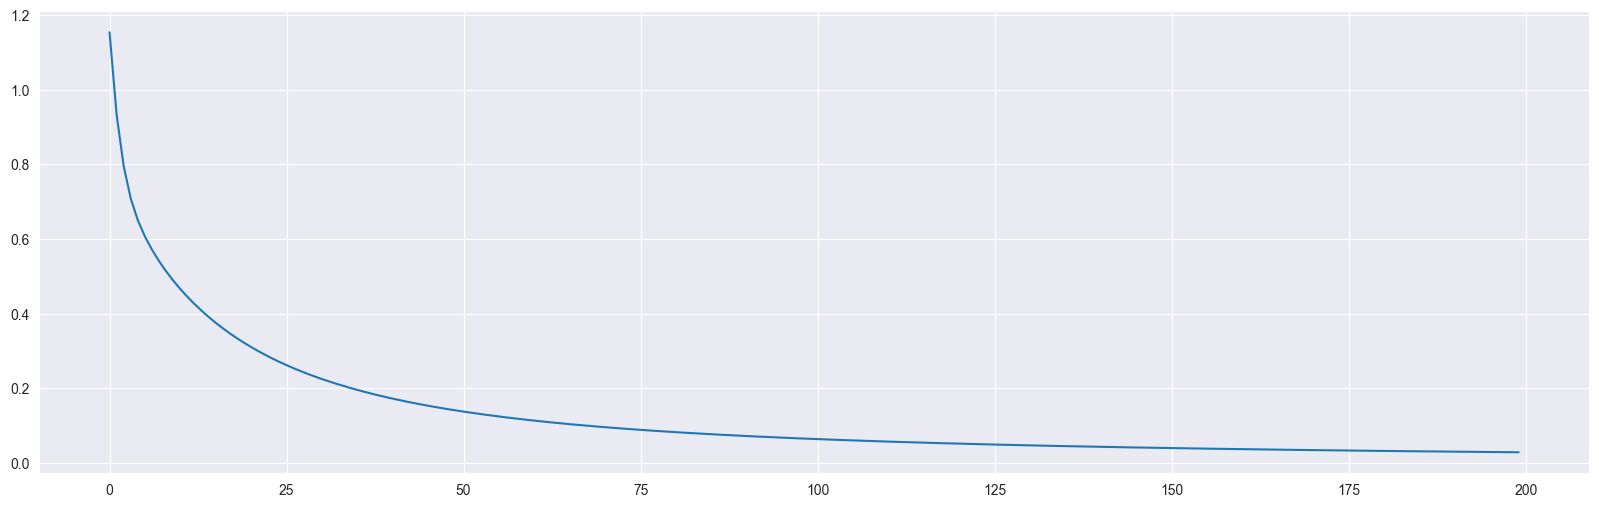

In [10]:
plt.plot(loss_epoches)

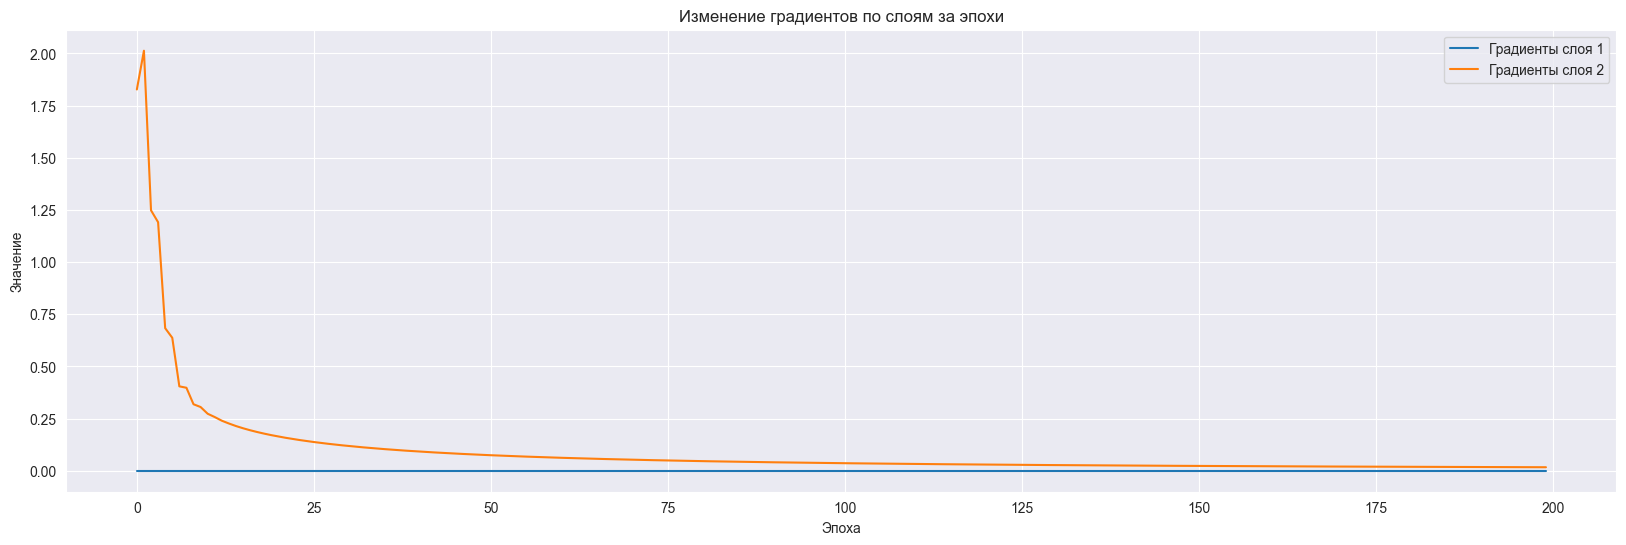

In [11]:
# Визуализация градиентов на одном графике
for layer in range(dW_epoches.shape[0]):
    plt.plot(range(epochs), dW_epoches[layer, :], label=f'Градиенты слоя {layer + 1}')

plt.title('Изменение градиентов по слоям за эпохи')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.legend(loc='upper right')  # Легенда для обозначения линий
plt.grid(True)  # Сетка для лучшего визуального восприятия
plt.show()

In [12]:
print(mlp_test.db)

[array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), array([[0.07988272]])]


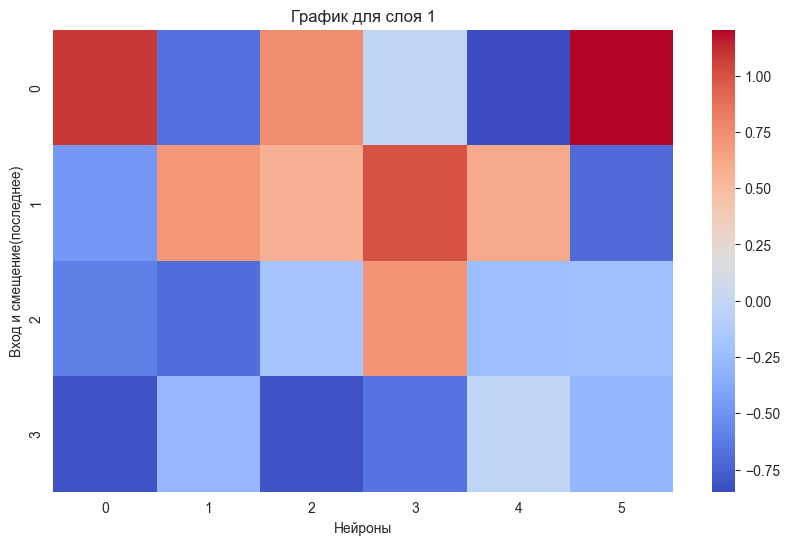

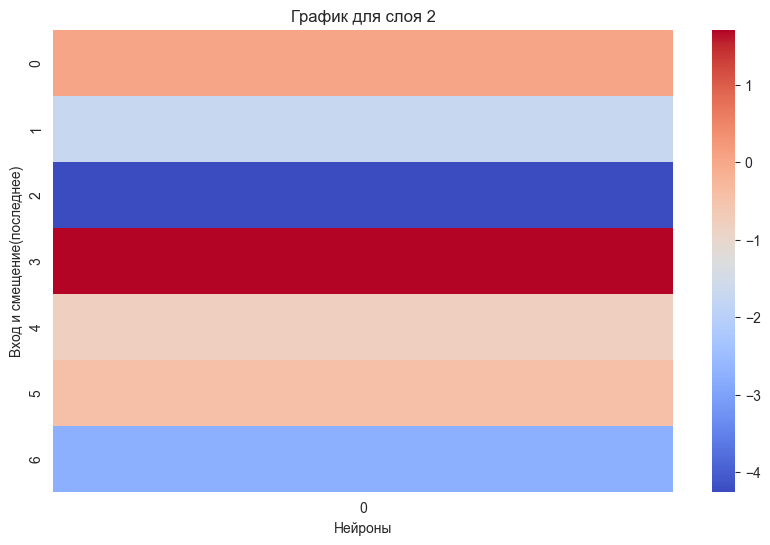

In [13]:
visualize_weights_with_biases(mlp_test.W, mlp_test.b)